In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load data about environment specs
env_data = pd.read_csv("data/env_data.csv", index_col=0).set_index("Environment")
env_data.head()

,Instance,vcpu,cpu_mem (GiB),cpu_type,gpu,gpu_mem (GiB),gpu_type
Environment,,,,,,,
env1,c7a.medium,1,2.0,AMD EPYC Gen4,0,NaN,NaN
env2,c7a.large,2,4.0,AMD EPYC Gen4,0,NaN,NaN
env3,c7a.xlarge,4,8.0,AMD EPYC Gen4,0,NaN,NaN
env4,c7a.2xlarge,8,16.0,AMD EPYC Gen4,0,NaN,NaN
env5,c6i.xlarge,4,8.0,Intel Xeon 8375C (Ice Lake),0,NaN,NaN


## Data Cleaning (Runtime Data)
We will convert everything into milliseconds

In [3]:
""" runtime dataset
Each row is an environment trial 
    i.e., (env1 trial 1/2/3, env2 trial 1/2/3, ... , datahub trial1, ...)
Each column thereafter are for runtimes
    Example: c_CNN_time, how long this environment trial took to process the CNN exectuion on cpu
    Example: g_LSTM_time, how long this env trial took to process the LSTM execution on gpu
"""

runtime_data = pd.read_csv("data/runtime_data.csv", index_col=0)
runtime_data.tail()

,Environment,Trial,c_CNN_time,c_DNN_time,c_LSTM_time,c_transformer_time,g_CNN_time,g_DNN_time,g_transformer_time,g_LSTM_time
37,env8,2,18.588ms,99.798ms,166.293ms,350.000ms,NaN,NaN,NaN,NaN
38,env8,3,17.479ms,97.773ms,168.605ms,331.944ms,NaN,NaN,NaN,NaN
39,env9,1,15.990ms,52.985ms,126.101ms,206.221ms,NaN,NaN,NaN,NaN
40,env9,2,16.263ms,53.330ms,127.396ms,201.290ms,NaN,NaN,NaN,NaN
41,env9,3,15.607ms,55.033ms,128.863ms,187.897ms,NaN,NaN,NaN,NaN


In [4]:
""" Clean up the data (also convert to milliseconds) """

# Convert a messy string format of runtime to a float or np.nan
def standardize_time(time):
    if (type(time)==str and "[" not in time):
        time = time.strip()
        
        t = re.split(r'(\d+\.\d+)', time)
        t = [_ for _ in t if _ != '']
        
        if (t[1] == "ms"):
            return float(t[0])
        elif (t[1] == "s"):
            return float(t[0])*1000
        else:
            return np.nan
    elif (type(time)==str and "[" in time):
        time = time.strip('][').split(', ')
        time = [_.strip("'") for _ in time]
        out = []
        for i in range(len(time)):
            ti = time[i]
            t = re.split(r'(\d+\.\d+)', ti)
            t = [_ for _ in t if _ != '']

            if (t[1] == "ms"):
                out += [float(t[0])]
            elif (t[1] == "s"):
                out += [float(t[0])*1000]
            elif (t[1] == "us"):
                out += [float(t[0])/1000]
            else:
                out += [np.nan]
        return np.array(out)
    else:
        return time
    
for col in runtime_data.columns[2:]:
    runtime_data[col] = runtime_data[col].apply(standardize_time)

runtime_data.head()

,Environment,Trial,c_CNN_time,c_DNN_time,c_LSTM_time,c_transformer_time,g_CNN_time,g_DNN_time,g_transformer_time,g_LSTM_time
0,datahub1,1,10059.000,13676.000,87395.000,68193.000,"[1451.0, 1.159]","[22.576, 2.88]","[81.142, 9.617]",NaN
1,datahub10,1,22.238,50.162,274.854,261.713,"[1309.0, 0.93]","[11.884, 2.466]","[32.986, 6.056]",NaN
2,datahub2,1,4267.000,4488.000,62788.000,15780.000,"[1384.0, 1.154]","[17.723, 2.864]","[92.822, 9.504]",NaN
3,datahub3,1,675.796,1191.000,7188.000,4690.000,"[1573.0, 1.138]","[18.172, 2.858]","[60.954, 9.515]",NaN
4,datahub4,1,26.471,235.421,789.155,1127.000,"[1549.0, 1.174]","[20.413, 2.864]","[59.692, 9.808]",NaN


In [5]:
# merge the environment data with the runtime data
merged_data = runtime_data.merge(env_data, left_on="Environment", right_index=True, how="left")
merged_data.head()

,Environment,Trial,c_CNN_time,c_DNN_time,c_LSTM_time,c_transformer_time,g_CNN_time,g_DNN_time,g_transformer_time,g_LSTM_time,Instance,vcpu,cpu_mem (GiB),cpu_type,gpu,gpu_mem (GiB),gpu_type
0,datahub1,1,10059.000,13676.000,87395.000,68193.000,"[1451.0, 1.159]","[22.576, 2.88]","[81.142, 9.617]",NaN,NaN,1,32.0,Intel(R) Xeon(R) Gold 5218,1,NaN,2080ti
1,datahub10,1,22.238,50.162,274.854,261.713,"[1309.0, 0.93]","[11.884, 2.466]","[32.986, 6.056]",NaN,NaN,12,32.0,AMD EPYC 7543P,1,NaN,a5000
2,datahub2,1,4267.000,4488.000,62788.000,15780.000,"[1384.0, 1.154]","[17.723, 2.864]","[92.822, 9.504]",NaN,NaN,2,32.0,Intel(R) Xeon(R) Gold 5218,1,NaN,2080ti
3,datahub3,1,675.796,1191.000,7188.000,4690.000,"[1573.0, 1.138]","[18.172, 2.858]","[60.954, 9.515]",NaN,NaN,4,32.0,Intel(R) Xeon(R) Gold 5218,1,NaN,2080ti
4,datahub4,1,26.471,235.421,789.155,1127.000,"[1549.0, 1.174]","[20.413, 2.864]","[59.692, 9.808]",NaN,NaN,8,32.0,Intel(R) Xeon(R) Gold 5218,1,NaN,2080ti


## Data Analysis (Runtime Data)

#### First, Let's See what happened over each trial

In [6]:
""" For each environment, get the standard deviation between execution times """
runtime_data[runtime_data["Environment"].str.contains("env")].groupby("Environment").std().tail(10)

,Trial,c_CNN_time,c_DNN_time,c_LSTM_time,c_transformer_time,g_CNN_time,g_DNN_time,g_transformer_time,g_LSTM_time
Environment,,,,,,,,,
env1,1.0,33.502204,0.626773,43.657995,8.652378,NaN,NaN,NaN,NaN
env10,1.0,0.512892,0.267948,1.634813,1.726022,NaN,NaN,NaN,NaN
env2,1.0,5.789247,1.807132,1.378854,2.638770,NaN,NaN,NaN,NaN
env3,1.0,0.199592,0.927694,0.805093,0.364291,NaN,NaN,NaN,NaN
env4,1.0,0.100553,0.144128,2.164567,0.592841,NaN,NaN,NaN,NaN
env5,1.0,0.162004,19.102551,46.117691,14.166294,NaN,NaN,NaN,NaN
env6,1.0,0.232080,0.949089,1.735024,9.689483,NaN,NaN,NaN,NaN
env7,1.0,0.089538,0.119302,0.799706,9.563330,NaN,NaN,NaN,NaN
env8,1.0,0.555749,1.720111,1.410556,10.848821,NaN,NaN,NaN,NaN


It seems that a lot of the environment with multiple trials saw a big difference between trials. However, we are in milliseconds, so a standard deviation of 33 (which seems huge), is only a result of 71 ms vs 13 ms. Again, this seems big, but we are in milliseconds, where this difference is actually miniscule.

#### Let's take the average over all trials

In [7]:
mean_trials = runtime_data.groupby("Environment").mean().drop(columns=["Trial"])
mean_trials

,c_CNN_time,c_DNN_time,c_LSTM_time,c_transformer_time,g_CNN_time,g_DNN_time,g_transformer_time,g_LSTM_time
Environment,,,,,,,,
datahub1,10059.000000,13676.000000,8.739500e+04,68193.000000,"[1451.0, 1.159]","[22.576, 2.88]","[81.142, 9.617]",NaN
datahub10,22.238000,50.162000,2.748540e+02,261.713000,"[1309.0, 0.93]","[11.884, 2.466]","[32.986, 6.056]",NaN
datahub2,4267.000000,4488.000000,6.278800e+04,15780.000000,"[1384.0, 1.154]","[17.723, 2.864]","[92.822, 9.504]",NaN
datahub3,675.796000,1191.000000,7.188000e+03,4690.000000,"[1573.0, 1.138]","[18.172, 2.858]","[60.954, 9.515]",NaN
datahub4,26.471000,235.421000,7.891550e+02,1127.000000,"[1549.0, 1.174]","[20.413, 2.864]","[59.692, 9.808]",NaN
datahub5,119.312000,147.005000,8.130410e+02,495.764000,"[1469.0, 1.139]","[16.187, 2.862]","[57.146, 9.494]",NaN
datahub6,19016.000000,55.792000,1.971799e+06,166497.000000,"[1115.0, 0.935]","[12.194, 2.468]","[41.017, 6.058]",NaN
datahub7,8634.000000,46.449000,9.039160e+05,67301.000000,"[1240.0, 0.935]","[12.7, 2.475]","[33.814, 6.028]",NaN
datahub8,291.756000,56.872000,9.098610e+02,6987.000000,"[1254.0, 0.932]","[20.241, 2.464]","[34.279, 6.034]",NaN


In [8]:
# merged the cpu type back
same_cpu_core = merged_data[merged_data['vcpu'] == 4].groupby("Environment").mean().drop(columns=["Trial"]).merge(env_data, left_on="Environment", right_index=True, how="left")
rows_to_keep = ['datahub3', 'datahub8', 'env3', 'env7']
same_cpu_core = same_cpu_core[same_cpu_core.index.isin(rows_to_keep)]

# plot the data, only use cnn, dnn, and T
# use stacked bar plot with seaborn
# put T on the bottom
fig, ax = plt.subplots(figsize=(10, 5))
barWidth = 0.25
bars1 = same_cpu_core['c_CNN_time']
bars2 = same_cpu_core['c_DNN_time']
bars3 = same_cpu_core['c_transformer_time']
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
plt.bar(r1, bars1, color='#003049', width=barWidth, label='CNN')
plt.bar(r2, bars2, color='#D62828', width=barWidth, label='DNN')
plt.bar(r3, bars3, color='#FCBF49', width=barWidth, label='Transformer')
plt.xlabel('CPU Name', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], same_cpu_core['cpu_type'])
# log scale
plt.yscale('log')
# y label logged
plt.ylabel('log(runtime) in ms', fontweight='bold')
plt.title('Runtime of CNN, DNN, and Transformer on quad-core CPUs', fontweight='bold', fontsize=15)

# Add exact numbers on each bar
for i, bar in enumerate(bars1):
    plt.text(i, bar + 0.1, str(round(bar, 2)), ha='center', va='bottom')
for i, bar in enumerate(bars2):
    plt.text(i + barWidth, bar, str(round(bar, 2)), ha='center', va='bottom')
for i, bar in enumerate(bars3):
    plt.text(i + 2 * barWidth, bar, str(round(bar, 2)), ha='center', va='bottom')

plt.legend()

# get rid the plot frame and keep the x and y axis
sns.despine()

plt.grid(axis='y', linestyle='--', alpha=0.2);

# smaller margin
plt.margins(0.06)

# better resolution retina
plt.savefig('runtime_cpu.png', dpi=1000)

TypeError: Could not convert c7a.xlargec7a.xlargec7a.xlarge to numeric

In [9]:
merged_data[(merged_data['gpu'] == 1) & (merged_data['cpu_type'] == "Intel(R) Xeon(R) Gold 5218")].sort_values(by=['vcpu', 'cpu_type'], ascending=False)

,Environment,Trial,c_CNN_time,c_DNN_time,c_LSTM_time,c_transformer_time,g_CNN_time,g_DNN_time,g_transformer_time,g_LSTM_time,Instance,vcpu,cpu_mem (GiB),cpu_type,gpu,gpu_mem (GiB),gpu_type
5,datahub5,1,119.312,147.005,813.041,495.764,"[1469.0, 1.139]","[16.187, 2.862]","[57.146, 9.494]",NaN,NaN,12,32.0,Intel(R) Xeon(R) Gold 5218,1,NaN,2080ti
4,datahub4,1,26.471,235.421,789.155,1127.000,"[1549.0, 1.174]","[20.413, 2.864]","[59.692, 9.808]",NaN,NaN,8,32.0,Intel(R) Xeon(R) Gold 5218,1,NaN,2080ti
3,datahub3,1,675.796,1191.000,7188.000,4690.000,"[1573.0, 1.138]","[18.172, 2.858]","[60.954, 9.515]",NaN,NaN,4,32.0,Intel(R) Xeon(R) Gold 5218,1,NaN,2080ti
2,datahub2,1,4267.000,4488.000,62788.000,15780.000,"[1384.0, 1.154]","[17.723, 2.864]","[92.822, 9.504]",NaN,NaN,2,32.0,Intel(R) Xeon(R) Gold 5218,1,NaN,2080ti
0,datahub1,1,10059.000,13676.000,87395.000,68193.000,"[1451.0, 1.159]","[22.576, 2.88]","[81.142, 9.617]",NaN,NaN,1,32.0,Intel(R) Xeon(R) Gold 5218,1,NaN,2080ti


In [10]:
# create the same plot as the cell above but in plotly
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Bar(x=same_cpu_core['cpu_type'], y=same_cpu_core['c_CNN_time'], name='CNN', marker_color='#003049'))
fig.add_trace(go.Bar(x=same_cpu_core['cpu_type'], y=same_cpu_core['c_DNN_time'], name='DNN', marker_color='#D62828'))
fig.add_trace(go.Bar(x=same_cpu_core['cpu_type'], y=same_cpu_core['c_T_time'], name='Transformer', marker_color='#FCBF49'))

fig.update_layout(
    title='Runtime of CNN, DNN, and Transformer on quad-core CPUs',
    xaxis=dict(
        title='CPU Name',
        titlefont_size=16,
        tickfont_size=14,
    ),
    yaxis=dict(
        title='Log(CPU Runtime) (ms)',
        titlefont_size=16,
        tickfont_size=14,
        type='log'
    ),
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1
)

# use black text 
fig.update_traces(textposition='outside', textfont_size=14)

# bold the title and axis
fig.update_layout(title_font_size=20, title_font_family='Arial')
fig.update_xaxes(title_font_size=18, title_font_family='Arial')
fig.update_yaxes(title_font_size=18, title_font_family='Arial')

fig.show()
# export it to html
fig.write_html("docs/runtime_cpu.html")

NameError: name 'same_cpu_core' is not defined

In [ ]:
same_cpu_core

In [ ]:
""" Filter out the non-aws environments """
aws = mean_trials.reset_index()[~mean_trials.reset_index()["Environment"].str.contains("datahub")]
aws = aws.reset_index(drop=True)
aws

## Experiment 1 - Scaling vCPU and CPU memory
Recall that env1-env4 are the exact same systems, just with gradually and equally scaling vcpus and cpu memory.

In [11]:
""" Data Relevant to Experiment 1 """

exp1 = aws[aws["Environment"].isin(["env1","env2","env3","env4"])].iloc[:,:5]
exp1 = exp1.set_index("Environment")
exp1["Instance"] = env_data["Instance"]
exp1

NameError: name 'aws' is not defined

,vcpu,cpu_mem (GiB),cpu_type
Instance,,,
c7a.medium,1,2.0,AMD EPYC Gen4
c7a.large,2,4.0,AMD EPYC Gen4
c7a.xlarge,4,8.0,AMD EPYC Gen4
c7a.2xlarge,8,16.0,AMD EPYC Gen4


NameError: name 'exp1' is not defined

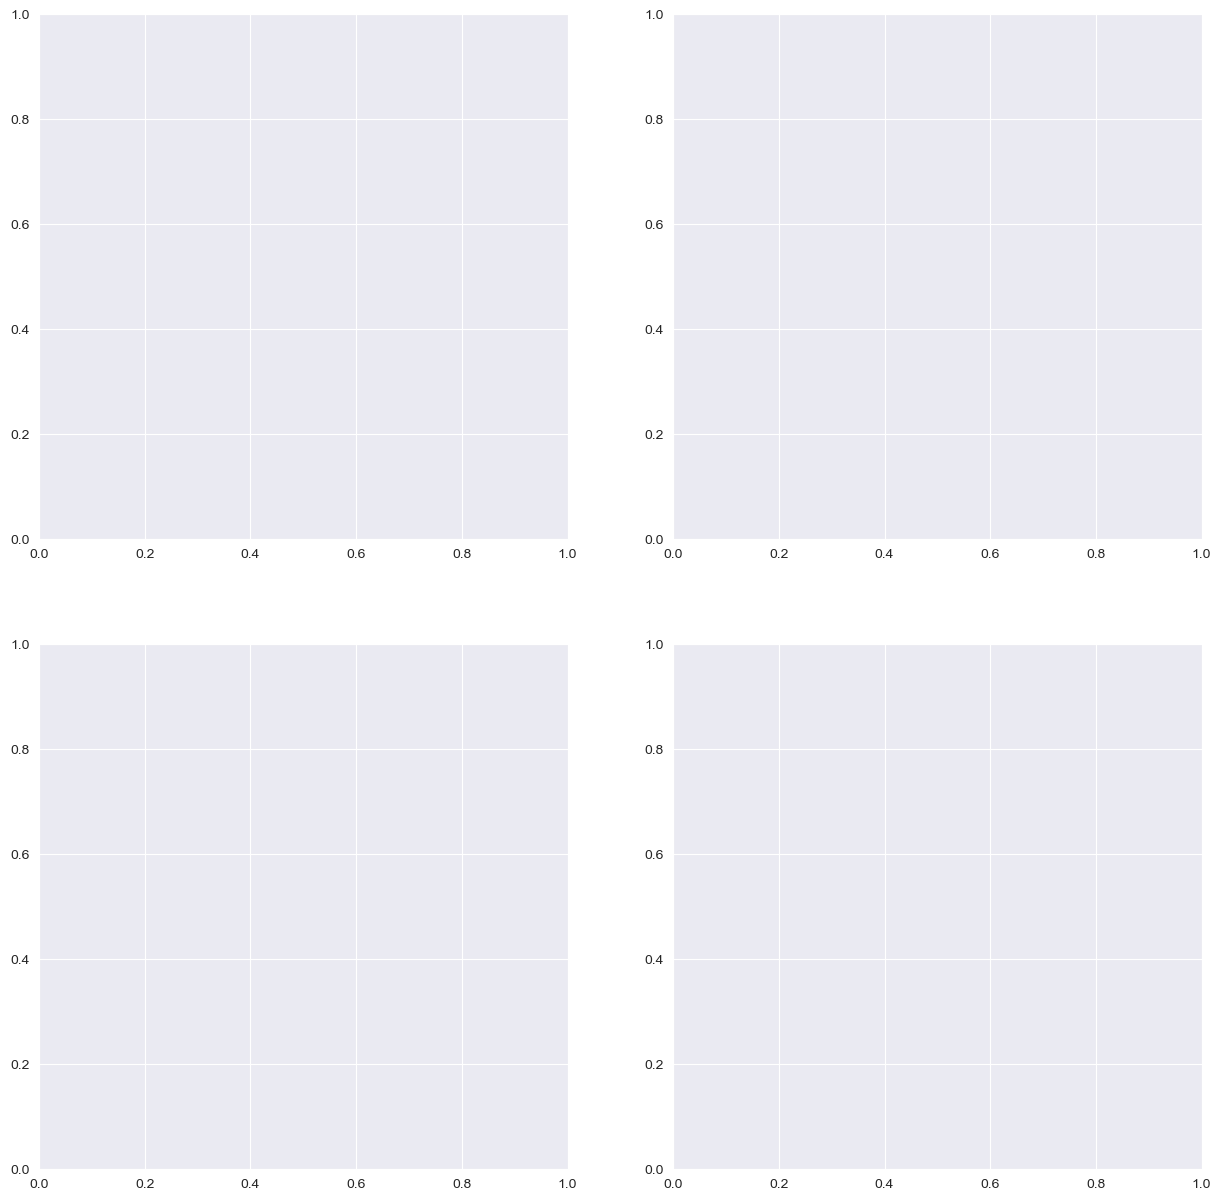

In [12]:
e1_legend = env_data[env_data.index.isin(["env1","env2","env3","env4"])].iloc[:,:4]
e1_legend = e1_legend.reset_index(drop=True).set_index("Instance")
display(e1_legend)

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

sns.barplot(exp1, x="Instance", y="c_CNN_time", ax=axs[0][0]);
axs[0][0].set_ylabel('CPU Runtime (ms)', size=15)
axs[0][0].set_xlabel('Instance', size=15);
axs[0][0].set_title('CNN', size=20);

sns.barplot(exp1, x="Instance", y="c_DNN_time", ax=axs[0][1]);
axs[0][1].set_ylabel('CPU Runtime (ms)', size=15)
axs[0][1].set_xlabel('Instance', size=15);
axs[0][1].set_title('DNN', size=20);

sns.barplot(exp1, x="Instance", y="c_LSTM_time", ax=axs[1][0]);
axs[1][0].set_ylabel('CPU Runtime (ms)', size=15)
axs[1][0].set_xlabel('Instance', size=15);
axs[1][0].set_title('LSTM', size=20);

sns.barplot(exp1, x="Instance", y="c_transformer_time", ax=axs[1][1]);
axs[1][1].set_ylabel('CPU Runtime (ms)', size=15)
axs[1][1].set_xlabel('Instance', size=15);
axs[1][1].set_title('Transformer', size=20);

In [ ]:
# put all four plots on the same plot, use line instead
# make the plot smaller
# add the dots  
fig, axs = plt.subplots(1, 1, figsize=(8, 5))
sns.lineplot(data=exp1, x="Instance", y="c_CNN_time", marker="o", label="CNN", color="#003049", linewidth=2.5);
sns.lineplot(data=exp1, x="Instance", y="c_DNN_time", marker="o", label="DNN", color="#D62828", linewidth=2.5);
sns.lineplot(data=exp1, x="Instance", y="c_LSTM_time", marker="o", label="LSTM", color="#F77F00", linewidth=2.5);
sns.lineplot(data=exp1, x="Instance", y="c_T_time", marker="o", label="Transformer", color="#FCBF49", linewidth=2.5);



# bold the labels and the title
plt.ylabel('CPU Runtime (ms)', fontweight='bold')
plt.xlabel('Number of Virtual CPU Cores', fontweight='bold')
plt.title('Runtime on Different Virtual CPU Cores', fontweight='bold', fontsize=15)
axs.set_xticklabels(e1_legend.apply(lambda row: f"{row[0]}", axis=1))
plt.legend()
# get rid the plot frame and keep the x and y axis
sns.despine()

plt.grid(axis='y', linestyle='dotted', alpha=0.45);

# smaller margin
plt.margins(0.06)
plt.savefig('runtime_vcpu.png', dpi=1000)
plt.show()

In [ ]:
# create the same plot as the cell above but in plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=e1_legend['vcpu'], y=exp1['c_CNN_time'], mode='lines+markers', name='CNN', marker_color='#003049'))
fig.add_trace(go.Scatter(x=e1_legend['vcpu'], y=exp1['c_DNN_time'], mode='lines+markers', name='DNN', marker_color='#D62828'))
fig.add_trace(go.Scatter(x=e1_legend['vcpu'], y=exp1['c_LSTM_time'], mode='lines+markers', name='LSTM', marker_color='#F77F00'))
fig.add_trace(go.Scatter(x=e1_legend['vcpu'], y=exp1['c_T_time'], mode='lines+markers', name='Transformer', marker_color='#FCBF49'))

fig.update_layout(
    title='Runtime on Different Virtual CPU Cores',
    xaxis=dict(
        title='Number of Virtual CPU Cores',
        titlefont_size=16,
        tickfont_size=14,
    ),
    yaxis=dict(
        title='Runtime (ms)',
        titlefont_size=16,
        tickfont_size=14,
    )
)

# bold the title and axis
fig.update_layout(title_font_size=20, title_font_family='Arial')
fig.update_xaxes(title_font_size=18, title_font_family='Arial')
fig.update_yaxes(title_font_size=18, title_font_family='Arial')

fig.show()

fig.write_html("docs/runtime_vcpu.html")

In [13]:
e1_legend.apply(lambda row: f"vcpu: {row[0]}, mem (GiB): {row[1]}", axis=1)

Instance
c7a.medium      vcpu: 1, mem (GiB): 2.0
c7a.large       vcpu: 2, mem (GiB): 4.0
c7a.xlarge      vcpu: 4, mem (GiB): 8.0
c7a.2xlarge    vcpu: 8, mem (GiB): 16.0
dtype: object

It seems that for all the models except the DNN, the runtime got better as we scaled up the CPU specs. For the LSTM and CNN, we see a miniscule time gain between the last two environments.

The DNN model saw no correlation between CPU specs and runtime.

## Experiment 2 - Scaling CPU memory
Recall that env5-env7 all have the same CPU type with 4 virtual CPUs.

In exp2 we will increasingly scale the CPU memory.

In [14]:
""" Data Relevant to Experiment 2 """

exp2 = aws[aws["Environment"].isin(["env5","env6","env7"])].iloc[:,:5]
exp2 = exp2.set_index("Environment")
exp2["Instance"] = env_data["Instance"]
exp2

NameError: name 'aws' is not defined

,vcpu,cpu_mem (GiB),cpu_type
Instance,,,
c6i.xlarge,4,8.0,Intel Xeon 8375C (Ice Lake)
m6i.xlarge,4,16.0,Intel Xeon 8375C (Ice Lake)
r6i.xlarge,4,32.0,Intel Xeon 8375C (Ice Lake)


NameError: name 'exp2' is not defined

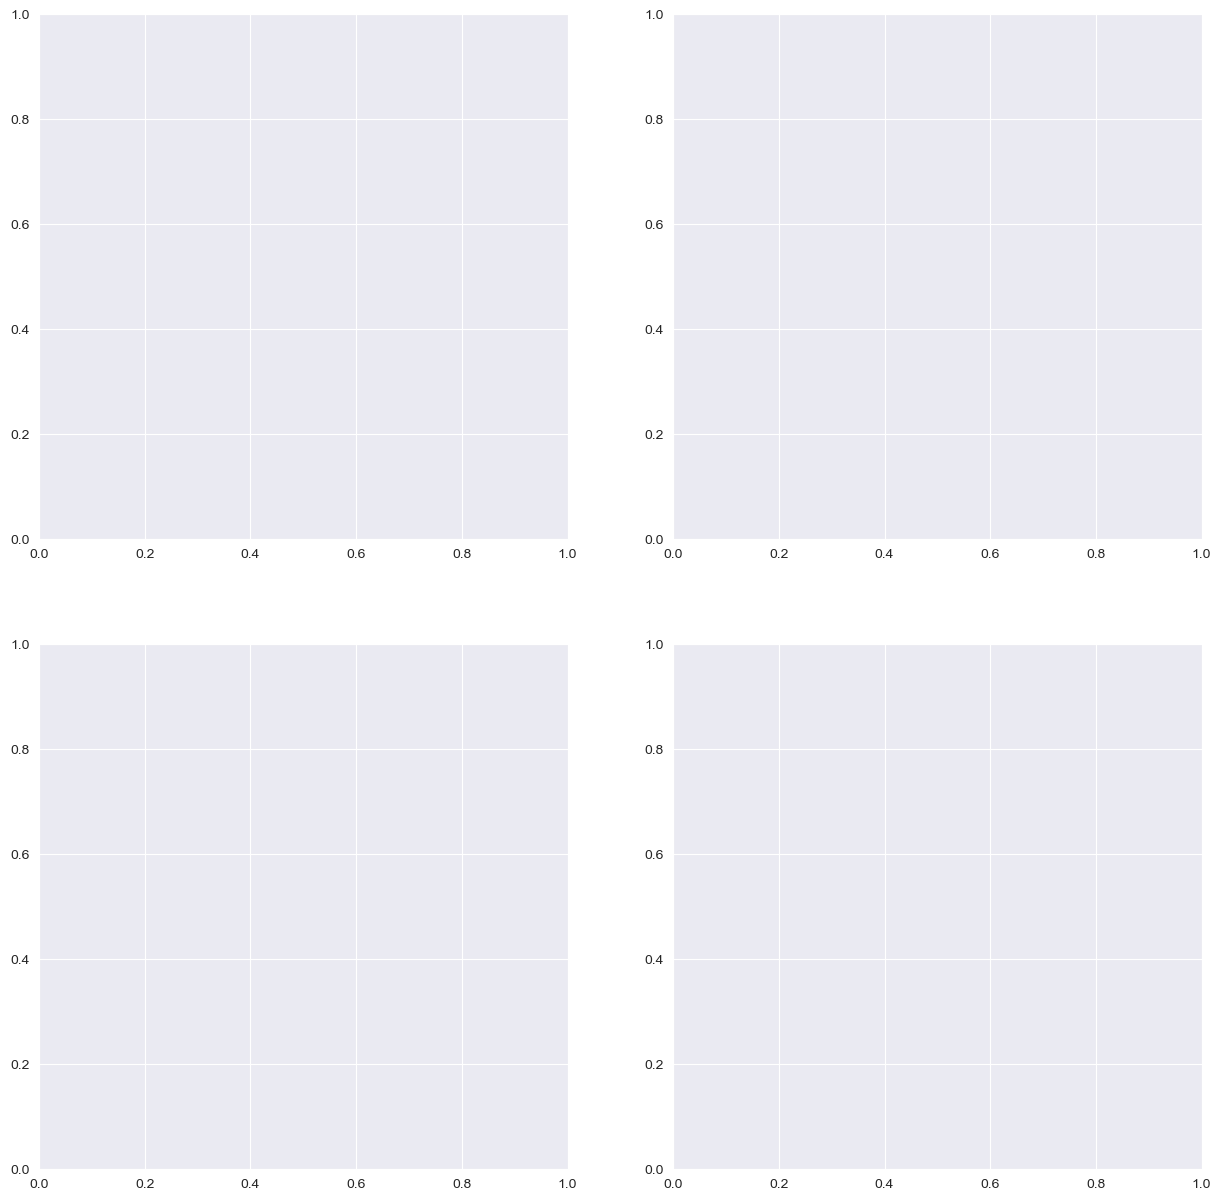

In [15]:
e2_legend = env_data[env_data.index.isin(["env5","env6","env7"])].iloc[:,:4]
e2_legend = e2_legend.reset_index(drop=True).set_index("Instance")
display(e2_legend)

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

sns.barplot(exp2, x="Instance", y="c_CNN_time", ax=axs[0][0]);
axs[0][0].set_ylabel('CPU Runtime (ms)', size=15)
axs[0][0].set_xlabel('Instance', size=15);
axs[0][0].set_title('CNN', size=20);

sns.barplot(exp2, x="Instance", y="c_DNN_time", ax=axs[0][1]);
axs[0][1].set_ylabel('CPU Runtime (ms)', size=15)
axs[0][1].set_xlabel('Instance', size=15);
axs[0][1].set_title('DNN', size=20);

sns.barplot(exp2, x="Instance", y="c_LSTM_time", ax=axs[1][0]);
axs[1][0].set_ylabel('CPU Runtime (ms)', size=15)
axs[1][0].set_xlabel('Instance', size=15);
axs[1][0].set_title('LSTM', size=20);

sns.barplot(exp2, x="Instance", y="c_transformer_time", ax=axs[1][1]);
axs[1][1].set_ylabel('CPU Runtime (ms)', size=15)
axs[1][1].set_xlabel('Instance', size=15);
axs[1][1].set_title('Transformer', size=20);

Above, we see a very slight increase in performace. Still, all the models achieve optimal runtimes when CPU memory is maximal.

Though, as we scale up to the second environment, sometimes we don't see any speed gains at all

## Experiment 3 - Scaling vCPUs
Recall that env8-env10 hold CPU memory constant at 16.0 GiB.

In exp3 we will increasingly scale the number of vCPUs.

In [16]:
""" Data Relevant to Experiment 3 """

exp3 = aws[aws["Environment"].isin(["env8","env9","env10"])].iloc[:,:5]
exp3 = exp3.set_index("Environment")
exp3["Instance"] = env_data["Instance"]
exp3 = exp3.reindex(["env8", "env9", "env10"])
exp3

NameError: name 'aws' is not defined

,vcpu,cpu_mem (GiB),cpu_type
Instance,,,
r6i.large,2,16.0,Intel Xeon 8375C (Ice Lake)
m6i.xlarge,4,16.0,Intel Xeon 8375C (Ice Lake)
c6i.2xlarge,8,16.0,Intel Xeon 8375C (Ice Lake)


NameError: name 'exp3' is not defined

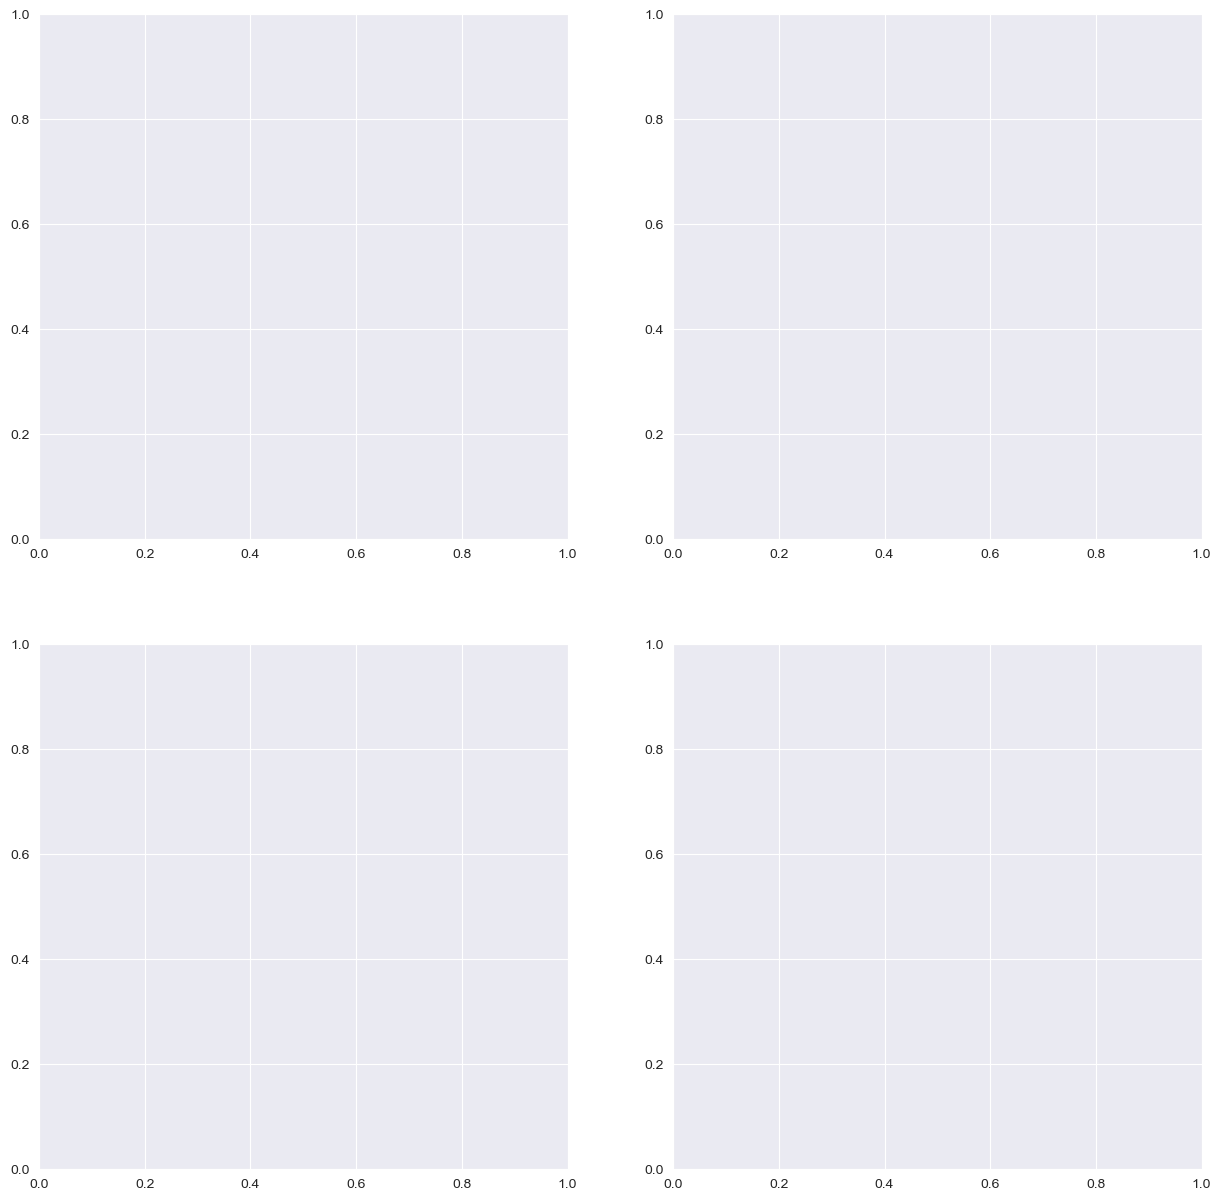

In [17]:
e3_legend = env_data[env_data.index.isin(["env8","env9","env10"])].iloc[:,:4]
e3_legend = e3_legend.reset_index(drop=True).set_index("Instance")
display(e3_legend)

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

sns.barplot(exp3, x="Instance", y="c_CNN_time", ax=axs[0][0]);
axs[0][0].set_ylabel('CPU Runtime (ms)', size=15)
axs[0][0].set_xlabel('Instance', size=15);
axs[0][0].set_title('CNN', size=20);

sns.barplot(exp3, x="Instance", y="c_DNN_time", ax=axs[0][1]);
axs[0][1].set_ylabel('CPU Runtime (ms)', size=15)
axs[0][1].set_xlabel('Instance', size=15);
axs[0][1].set_title('DNN', size=20);

sns.barplot(exp3, x="Instance", y="c_LSTM_time", ax=axs[1][0]);
axs[1][0].set_ylabel('CPU Runtime (ms)', size=15)
axs[1][0].set_xlabel('Instance', size=15);
axs[1][0].set_title('LSTM', size=20);

sns.barplot(exp3, x="Instance", y="c_transformer_time", ax=axs[1][1]);
axs[1][1].set_ylabel('CPU Runtime (ms)', size=15)
axs[1][1].set_xlabel('Instance', size=15);
axs[1][1].set_title('Transformer', size=20);

Again, we see an increase in performace, but is a lot more this time. So scaling the number of vCPUs produces much more performance gains than scaling the CPU memory.

## Experiment 4 - Introducing the Graphics Processing Unit
Here, we will attempt to hold CPU architecture constant while introducing different types of GPUs.

Given the publically available AWS instances, it was difficult to find instances with different GPUs that had the exact same CPU specs, though we did our best to hold them constant.

In [18]:
# Still needs data

## Datahub Data

In [19]:
""" Filter out the aws environments """
datahub = mean_trials.reset_index()[mean_trials.reset_index()["Environment"].str.contains("datahub")]
datahub = datahub.reset_index(drop=True)
datahub

,Environment,c_CNN_time,c_DNN_time,c_LSTM_time,c_transformer_time,g_CNN_time,g_DNN_time,g_transformer_time,g_LSTM_time
0,datahub1,10059.000,13676.000,87395.000,68193.000,"[1451.0, 1.159]","[22.576, 2.88]","[81.142, 9.617]",NaN
1,datahub10,22.238,50.162,274.854,261.713,"[1309.0, 0.93]","[11.884, 2.466]","[32.986, 6.056]",NaN
2,datahub2,4267.000,4488.000,62788.000,15780.000,"[1384.0, 1.154]","[17.723, 2.864]","[92.822, 9.504]",NaN
3,datahub3,675.796,1191.000,7188.000,4690.000,"[1573.0, 1.138]","[18.172, 2.858]","[60.954, 9.515]",NaN
4,datahub4,26.471,235.421,789.155,1127.000,"[1549.0, 1.174]","[20.413, 2.864]","[59.692, 9.808]",NaN
5,datahub5,119.312,147.005,813.041,495.764,"[1469.0, 1.139]","[16.187, 2.862]","[57.146, 9.494]",NaN
6,datahub6,19016.000,55.792,1971799.000,166497.000,"[1115.0, 0.935]","[12.194, 2.468]","[41.017, 6.058]",NaN
7,datahub7,8634.000,46.449,903916.000,67301.000,"[1240.0, 0.935]","[12.7, 2.475]","[33.814, 6.028]",NaN
8,datahub8,291.756,56.872,909.861,6987.000,"[1254.0, 0.932]","[20.241, 2.464]","[34.279, 6.034]",NaN
9,datahub9,83.435,49.028,380.283,701.389,"[1491.0, 0.936]","[11.83, 2.481]","[33.039, 6.075]",NaN


## Data Cleaning (Large Sample Data)
We will convert everything into milliseconds

In [20]:
large_sample_data = pd.read_csv("data/large_sample_data.csv", index_col=0)
large_sample_data.head()

,Environment,Trial,Hardware,Model,50_samples,100_samples,500_samples,1000_samples,2000_samples,5000_samples
0,datahub1,1,cpu,CNN,3.002286,6.584249,6.470419,9.318261566979345,NaN,14.207533
1,datahub1,1,cpu,DNN,5.385304,4.988414,10.940336,13.659167839039583,NaN,72.596683
2,datahub1,1,cpu,LSTM,60.165908,91.994842,219.343836,347.4516330069746,528.636919,NaN
3,datahub1,1,cpu,transformer,42.728319,53.884598,129.266172,226.27289840998128,NaN,NaN
4,datahub1,1,gpu,CNN,0.002214,0.002042,0.003591,0.003689524019137025,NaN,0.004648


In [21]:
def standardize_l_time(time):
    if (type(time)==float):
        if (time == np.nan):
            return time
        else:
            return time*1000
    else:
        return np.nan

for col in large_sample_data.columns[4:]:
    large_sample_data[col] = large_sample_data[col].apply(standardize_l_time).astype(float)

In [111]:
df = large_sample_data.drop(large_sample_data[(large_sample_data['Model'] == 'LSTM') | (large_sample_data['Model'] == 'transformer')].index)
df = df.drop(columns=['1000_samples', '2000_samples'])
df

,Environment,Trial,Hardware,Model,50_samples,100_samples,500_samples,5000_samples
0,datahub1,1,cpu,CNN,3002.285565,6584.249189,6470.418525,14207.533342
1,datahub1,1,cpu,DNN,5385.303890,4988.413676,10940.336152,72596.683331
4,datahub1,1,gpu,CNN,2.213949,2.042289,3.590692,4.648195
5,datahub1,1,gpu,DNN,0.870409,0.752317,0.970322,0.924379
7,datahub10,1,cpu,CNN,9.027534,9.553734,26.913412,337.870998
8,datahub10,1,cpu,DNN,16.661577,9.730204,29.965423,388.913819
11,datahub10,1,gpu,CNN,3.924221,2.721081,4.318901,5.595203
12,datahub10,1,gpu,DNN,0.963790,0.849560,0.834350,0.603960
14,datahub2,1,cpu,CNN,1101.482214,1089.674183,2041.979206,6005.461513
15,datahub2,1,cpu,DNN,673.115543,785.319421,1644.653149,16728.352576


## Data Analysis (Large Sample Data)

In [114]:
df['Model_Hardware'] = df['Model'] + ' ' + df['Hardware']
averages = df.groupby(['Model_Hardware'])[['50_samples', '100_samples', '500_samples', '5000_samples']].mean()
averages.columns = [col.split('_')[0] for col in averages.columns]
averages = averages.transpose()
new_order = ['DNN gpu', 'CNN gpu', 'DNN cpu', 'CNN cpu']
averages = averages[new_order]

Model_Hardware,"DNN, gpu","CNN, gpu","DNN, cpu","CNN, cpu"
50,0.796348,3.864594,823.180115,821.458632
100,0.676948,2.812408,932.486911,1135.075337
500,0.739404,4.458920,1714.133917,1245.180602
5000,2.006454,5.455082,9295.362978,2848.299135


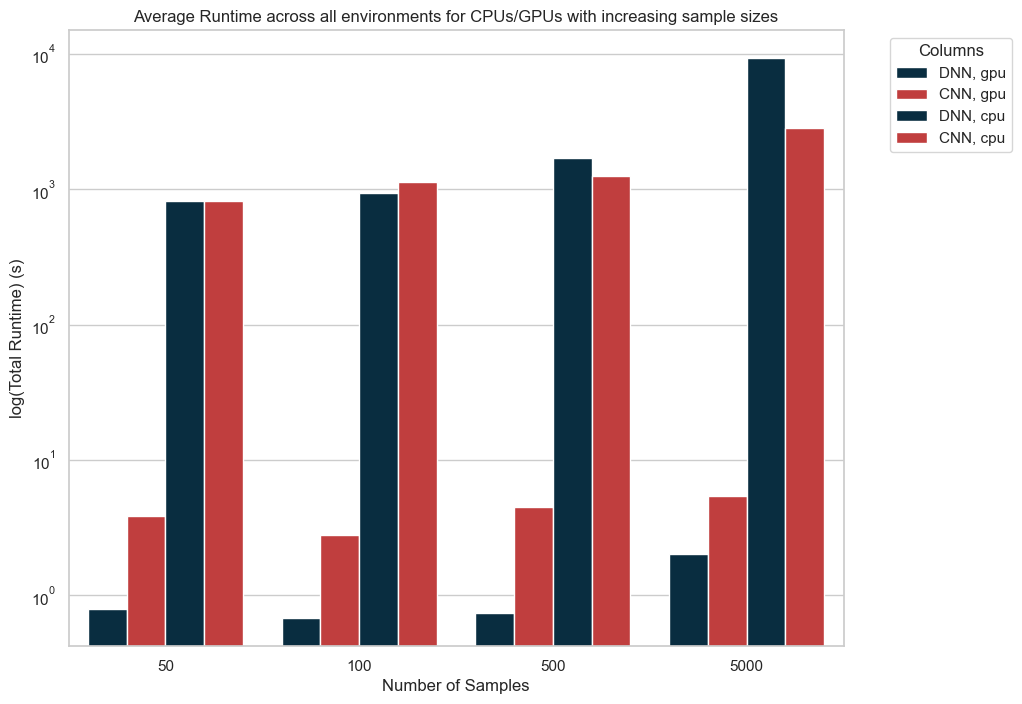

In [ ]:
df_melted = averages.reset_index().melt(id_vars='index', var_name='Column', value_name='Value')

colors = ["#003049", "#D62828", "#4d829e", "#e38484"]
# Plotting with Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(data=df_melted, x='index', y='Value', hue='Column', palette=colors)
plt.xlabel('Number of Samples')
plt.ylabel('log(Total Runtime) (s)')
plt.yscale('log')
plt.title('Average Runtime across all environments for CPUs/GPUs with increasing sample sizes')
plt.legend(title='Columns', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [104]:
?